In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
from copy import deepcopy
import datasets
import torch
from torch.utils.data import DataLoader
import transformers
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.models.frame_level import FrameLevelLexicalAccess, LexicalAccessDataCollator
from src.models.rnn import ExposedLSTM

In [5]:
dataset_path = "data/timit_phoneme"
model_checkpoint_path = "outputs/outputs_dualhead0.5/models/w2v2_drop6_rnn/checkpoint-5150/"
# model_checkpoint_path = "outputs/outputs_single_head_pre20231120/models/w2v2_drop6_rnn/checkpoint-2850/"
model_sfreq = 50
tokenizer_name = "charsiu/tokenizer_en_cmu"

In [6]:
test_dataset = datasets.load_from_disk(dataset_path)

In [7]:
model: FrameLevelLexicalAccess = FrameLevelLexicalAccess.from_pretrained(model_checkpoint_path)

tokenizer = transformers.Wav2Vec2Tokenizer.from_pretrained("charsiu/tokenizer_en_cmu")
feature_extractor = transformers.Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
processor = transformers.Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/userdata/jgauthier/transformers/lib/python3.10/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:792: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Model surgery: swap in exposed LSTM

In [8]:
collator = LexicalAccessDataCollator(
    processor=processor,
    model=model,
    padding=True,
    num_labels=model.config.num_labels,
    regression_target_size=model.config.regressor_target_size,
)

In [9]:
# dev_batch = collator(test_dataset["test"].select(range(2)))
#
# with torch.no_grad():
#     dev_forward_orig = model(**dev_batch)

In [10]:
rnn_state = deepcopy(model.rnn.state_dict())
exposed_lstm = ExposedLSTM(
    input_size=model.rnn.input_size,
    hidden_size=model.rnn.hidden_size,
    num_layers=model.rnn.num_layers,
    bias=model.rnn.bias,
    batch_first=model.rnn.batch_first,
)
exposed_lstm.load_state_dict(rnn_state)

model.rnn = exposed_lstm
model.config.expose_rnn = True

In [11]:
# with torch.no_grad():
#     dev_forward = model(output_hidden_states=True, **dev_batch)
#
# assert torch.allclose(dev_forward_orig.rnn_hidden_states,
#                       dev_forward.rnn_hidden_states[0][-1],
#                       rtol=1e-4, atol=1e-6)

## Collect forward pass representations on test set

In [12]:
def add_indices(item, idx):
    item["idx"] = idx
    return item
test_dataset = test_dataset.map(add_indices, batched=True, batch_size=2000, with_indices=True)

In [13]:
test_dataset_sub = test_dataset["test"]

In [14]:
# Flat representation of all hidden states etc.
flat_idxs = []
hidden_states, cell_states, input_gates, forget_gates, cell_gates, output_gates = \
    [], [], [], [], [], []

dataloader = DataLoader(test_dataset_sub, batch_size=8,
                        collate_fn=collator, shuffle=False)
for batch in tqdm(dataloader):
    with torch.no_grad():
        batch_output = model(output_hidden_states=True, **batch)

    batch_hidden, batch_cell, batch_input_gate, batch_forget_gate, batch_cell_gate, batch_output_gate = \
        batch_output.rnn_hidden_states
    batch_hidden = batch_hidden.permute(1, 2, 0, 3)
    batch_cell = batch_cell.permute(1, 2, 0, 3)
    batch_input_gate = batch_input_gate.permute(1, 2, 0, 3)
    batch_forget_gate = batch_forget_gate.permute(1, 2, 0, 3)
    batch_cell_gate = batch_cell_gate.permute(1, 2, 0, 3)
    batch_output_gate = batch_output_gate.permute(1, 2, 0, 3)

    # we are now in batch * seq_len * num_layers * hidden_size

    real_frames = batch.target_mask.sum(dim=1)
    for i, (idx) in enumerate(batch.idx):
        real_frames_i = real_frames[i]
        flat_idxs.extend([(idx.item(), i) for i in range(real_frames_i)])
        hidden_states.append(batch_hidden[i, :real_frames_i])
        cell_states.append(batch_cell[i, :real_frames_i])
        input_gates.append(batch_input_gate[i, :real_frames_i])
        forget_gates.append(batch_forget_gate[i, :real_frames_i])
        cell_gates.append(batch_cell_gate[i, :real_frames_i])
        output_gates.append(batch_output_gate[i, :real_frames_i])

  0%|          | 0/210 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/models/frame_level.py:247: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets[i][onset:offset, :] = torch.tensor(self.model.word_representations[word_id])
Unused kwargs: {'idx': tensor([0, 1, 2, 3, 4, 5, 6, 7])}
Unused kwargs: {'idx': tensor([ 8,  9, 10, 11, 12, 13, 14, 15])}
Unused kwargs: {'idx': tensor([16, 17, 18, 19, 20, 21, 22, 23])}
Unused kwargs: {'idx': tensor([24, 25, 26, 27, 28, 29, 30, 31])}
Unused kwargs: {'idx': tensor([32, 33, 34, 35, 36, 37, 38, 39])}
Unused kwargs: {'idx': tensor([40, 41, 42, 43, 44, 45, 46, 47])}
Unused kwargs: {'idx': tensor([48, 49, 50, 51, 52, 53, 54, 55])}
Unused kwargs: {'idx': tensor([56, 57, 58, 59, 60, 61, 62, 63])}
Unused kwargs: {'idx': tensor([64, 65, 66, 67, 68, 69, 70, 71])}
Unused kwargs: {'idx': tensor([72, 73, 74, 75, 76, 77

In [15]:
hidden_states = torch.cat(hidden_states, dim=0).numpy()
cell_states = torch.cat(cell_states, dim=0).numpy()
input_gates = torch.cat(input_gates, dim=0).numpy()
forget_gates = torch.cat(forget_gates, dim=0).numpy()
cell_gates = torch.cat(cell_gates, dim=0).numpy()
output_gates = torch.cat(output_gates, dim=0).numpy()

In [16]:
assert len(flat_idxs) == len(hidden_states)

In [17]:
boundary_event_names = ["file", "phoneme", "word"]
boundary_event_to_idx = {event_name: i for i, event_name in enumerate(boundary_event_names)}
boundary_matrix = np.zeros((hidden_states.shape[0], len(boundary_event_names)))
hidden_state_source_to_flat_idx = {idx: i for i, idx in enumerate(flat_idxs)}

def add_boundaries(item, idx, boundary_matrix, boundary_event_to_idx, hidden_state_source_to_flat_idx):
    compression_ratio = (model.encoder._get_feat_extract_output_lengths(len(item["input_values"])) / len(item["input_values"])).item()

    file_start_idx = hidden_state_source_to_flat_idx[(idx, 0)]
    boundary_matrix[file_start_idx, boundary_event_to_idx["file"]] = 1

    for word in item["word_phonemic_detail"]:
        if len(word) == 0:
            continue

        word_start = int(word[0]["start"] * compression_ratio)
        word_start_idx = hidden_state_source_to_flat_idx[(idx, word_start)]
        boundary_matrix[word_start_idx, boundary_event_to_idx["word"]] = 1

        for phoneme in word:
            phoneme_start = int(phoneme["start"] * compression_ratio)
            phoneme_start_idx = hidden_state_source_to_flat_idx[(idx, phoneme_start)]
            boundary_matrix[phoneme_start_idx, boundary_event_to_idx["phoneme"]] = 1

    return None

test_dataset_sub.map(add_boundaries, batched=False, with_indices=True,
                     fn_kwargs={"boundary_matrix": boundary_matrix, "boundary_event_to_idx": boundary_event_to_idx,
                                "hidden_state_source_to_flat_idx": hidden_state_source_to_flat_idx})

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'phonemic_detail', 'word_phonetic_detail', 'word_phonemic_detail', 'input_values', 'phone_targets', 'idx'],
    num_rows: 1680
})

In [18]:
from src.analysis.trf import estimate_trf_cv

## Gate norm time series analysis

In [19]:
gate_norms = np.concatenate([
    np.linalg.norm(input_gates, axis=2),
    np.linalg.norm(forget_gates, axis=2),
    np.linalg.norm(cell_gates, axis=2),
    np.linalg.norm(output_gates, axis=2),
], axis=1)
gate_norm_labels = [f"{gate_name} {layer_idx}"
                    for gate_name in ["input", "forget", "cell", "output"]
                    for layer_idx in range(model.rnn.num_layers)]

In [20]:
trf_df = estimate_trf_cv(boundary_matrix, gate_norms, gate_norm_labels,
                         tmin=-5, tmax=20, sfreq=1, feature_names=boundary_event_names)

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

In [21]:
trf_df[["gate", "layer"]] = trf_df["output_name"].str.split(" ", expand=True)

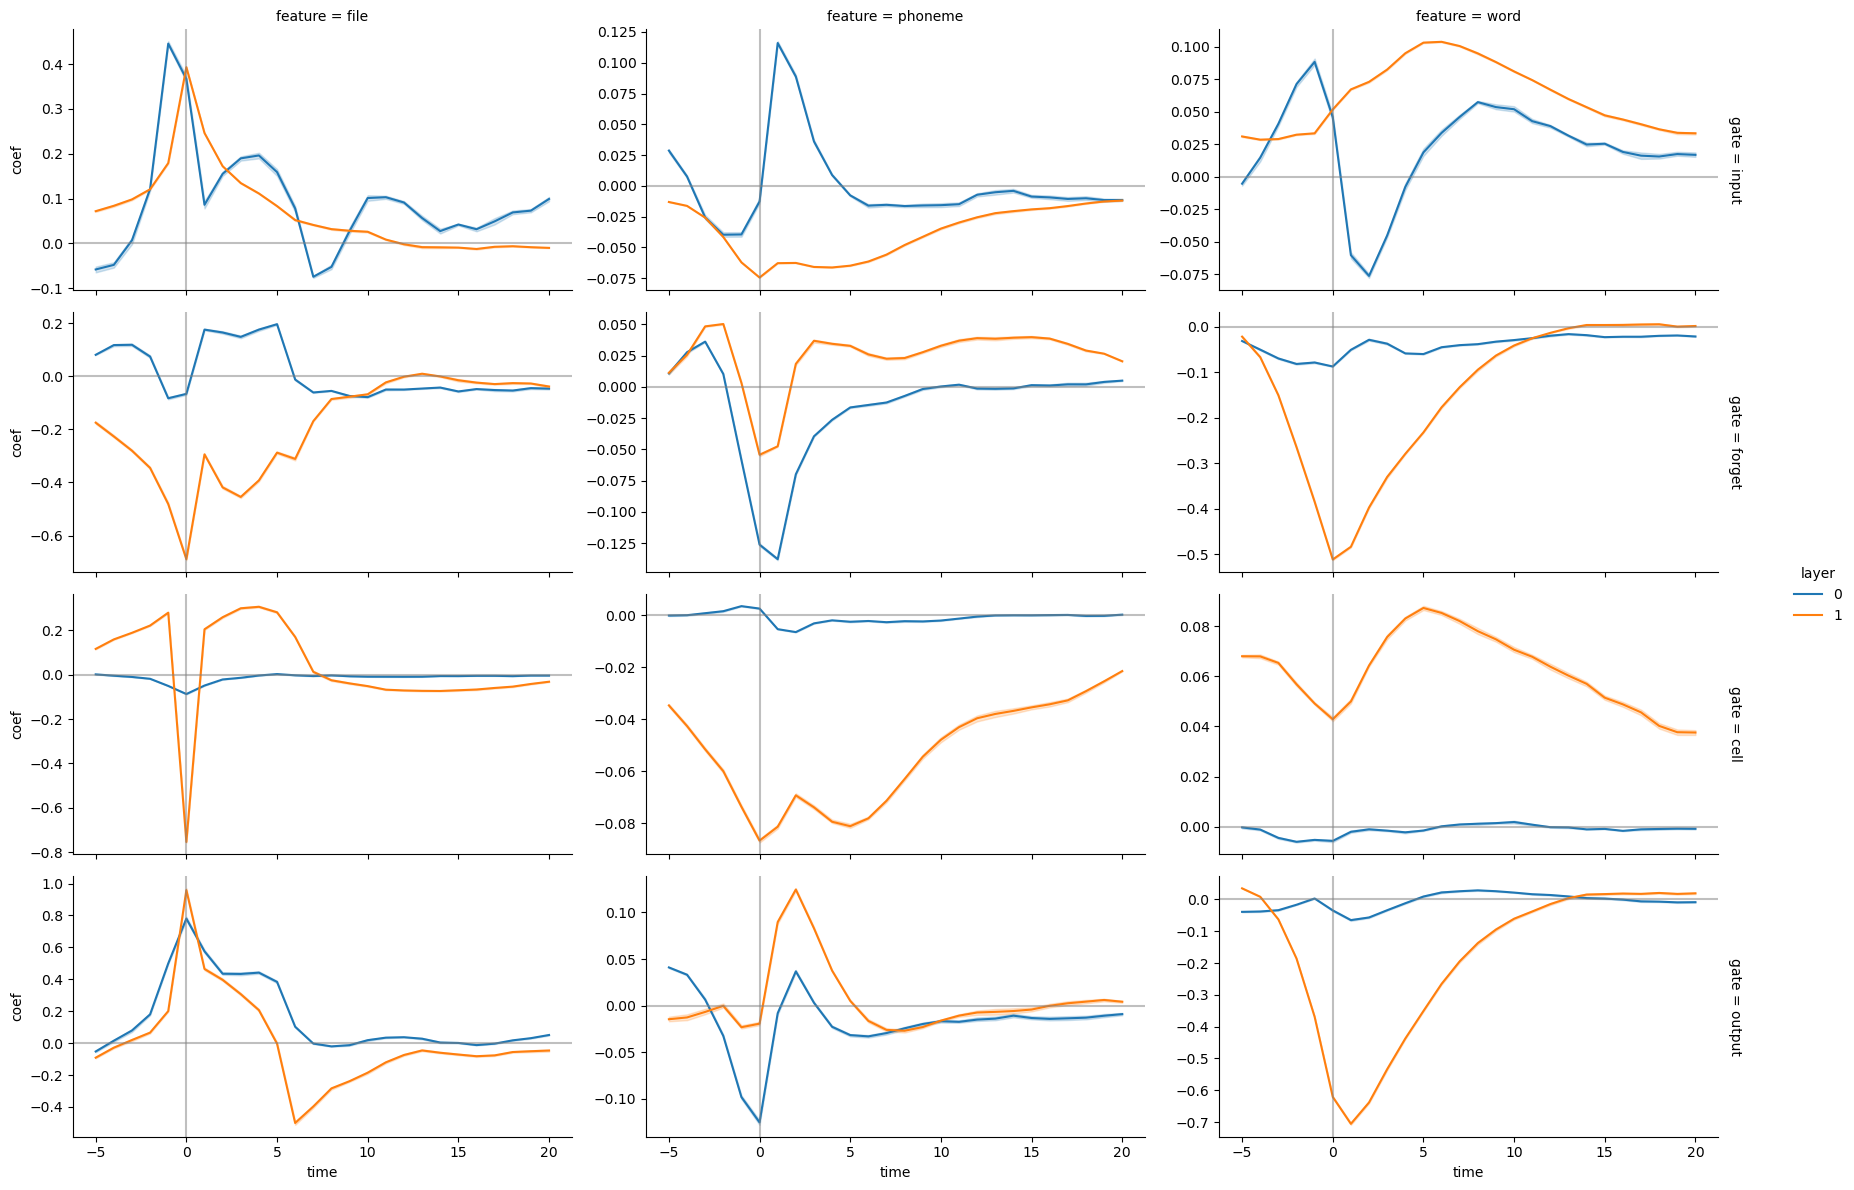

In [22]:
g = sns.FacetGrid(trf_df, row="gate", col="feature", hue="layer", sharey=False, margin_titles=True, aspect=2)
g.map(sns.lineplot, "time", "coef")
g.add_legend()

for ax in g.axes.flat:
    ax.axvline(0, color="gray", alpha=0.5)
    ax.axhline(0, color="gray", alpha=0.5)

## Gate PCA time series analysis

In [23]:
# Mask out regions of the signal where we are not within the span of a sentence
span_mask = np.zeros((len(boundary_matrix)), dtype=np.bool)
def update_mask(item, idx):
    compression_ratio = (model.encoder._get_feat_extract_output_lengths(len(item["input_values"])) / len(item["input_values"])).item()

    start_frame = int(item["word_detail"]["start"][0] * compression_ratio)
    stop_frame = int(item["word_detail"]["stop"][-1] * compression_ratio)

    start_flat_idx = hidden_state_source_to_flat_idx[(idx, start_frame)]
    stop_flat_idx = hidden_state_source_to_flat_idx[(idx, stop_frame)]

    span_mask[start_flat_idx:stop_flat_idx] = True
test_dataset_sub.map(update_mask, with_indices=True)

/tmp/ipykernel_3635488/2124684358.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  span_mask = np.zeros((len(boundary_matrix)), dtype=np.bool)


Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'phonemic_detail', 'word_phonetic_detail', 'word_phonemic_detail', 'input_values', 'phone_targets', 'idx'],
    num_rows: 1680
})

In [24]:
n_components = 2

gate_pcas, gate_pca_labels = [], []
for gate_name, gate in zip(tqdm(["input", "forget", "cell", "output"]),
                           [input_gates, forget_gates, cell_gates, output_gates]):
    for layer in range(gate.shape[1]):
        # Only use the within-sentence spans to fit PCA on hidden states
        data_for_pca_fit = gate[span_mask, layer]

        gate_pcas.append(PCA(n_components=n_components).fit(data_for_pca_fit).transform(gate[:, layer]))
        gate_pca_labels.extend([f"{gate_name} {layer} {component}" for component in range(n_components)])

gate_pcas = np.concatenate(gate_pcas, axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

In [25]:
trf_df = estimate_trf_cv(boundary_matrix, gate_pcas, gate_pca_labels,
                         tmin=-5, tmax=20, sfreq=1, feature_names=boundary_event_names)

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

In [26]:
# trf_df = pd.DataFrame(trf_to_df(trf, gate_pca_labels))
trf_df[["gate", "layer", "component"]] = trf_df["output_name"].str.split(" ", expand=True)
trf_df["layer_component"] = trf_df["layer"] + " " + trf_df["component"]
trf_df

,fold,level_1,feature,output_name,input_dim,output_dim,lag,time,coef,gate,layer,component,layer_component
0,0,0,file,input 0 0,0,0,-5,-5.0,-0.189326,input,0,0,0 0
1,0,1,file,input 0 0,0,0,-4,-4.0,-0.097995,input,0,0,0 0
2,0,2,file,input 0 0,0,0,-3,-3.0,0.164442,input,0,0,0 0
3,0,3,file,input 0 0,0,0,-2,-2.0,0.626199,input,0,0,0 0
4,0,4,file,input 0 0,0,0,-1,-1.0,2.167931,input,0,0,0 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6235,4,1243,word,output 1 1,2,15,16,16.0,-0.093294,output,1,1,1 1
6236,4,1244,word,output 1 1,2,15,17,17.0,-0.092475,output,1,1,1 1
6237,4,1245,word,output 1 1,2,15,18,18.0,-0.088974,output,1,1,1 1
6238,4,1246,word,output 1 1,2,15,19,19.0,-0.079256,output,1,1,1 1


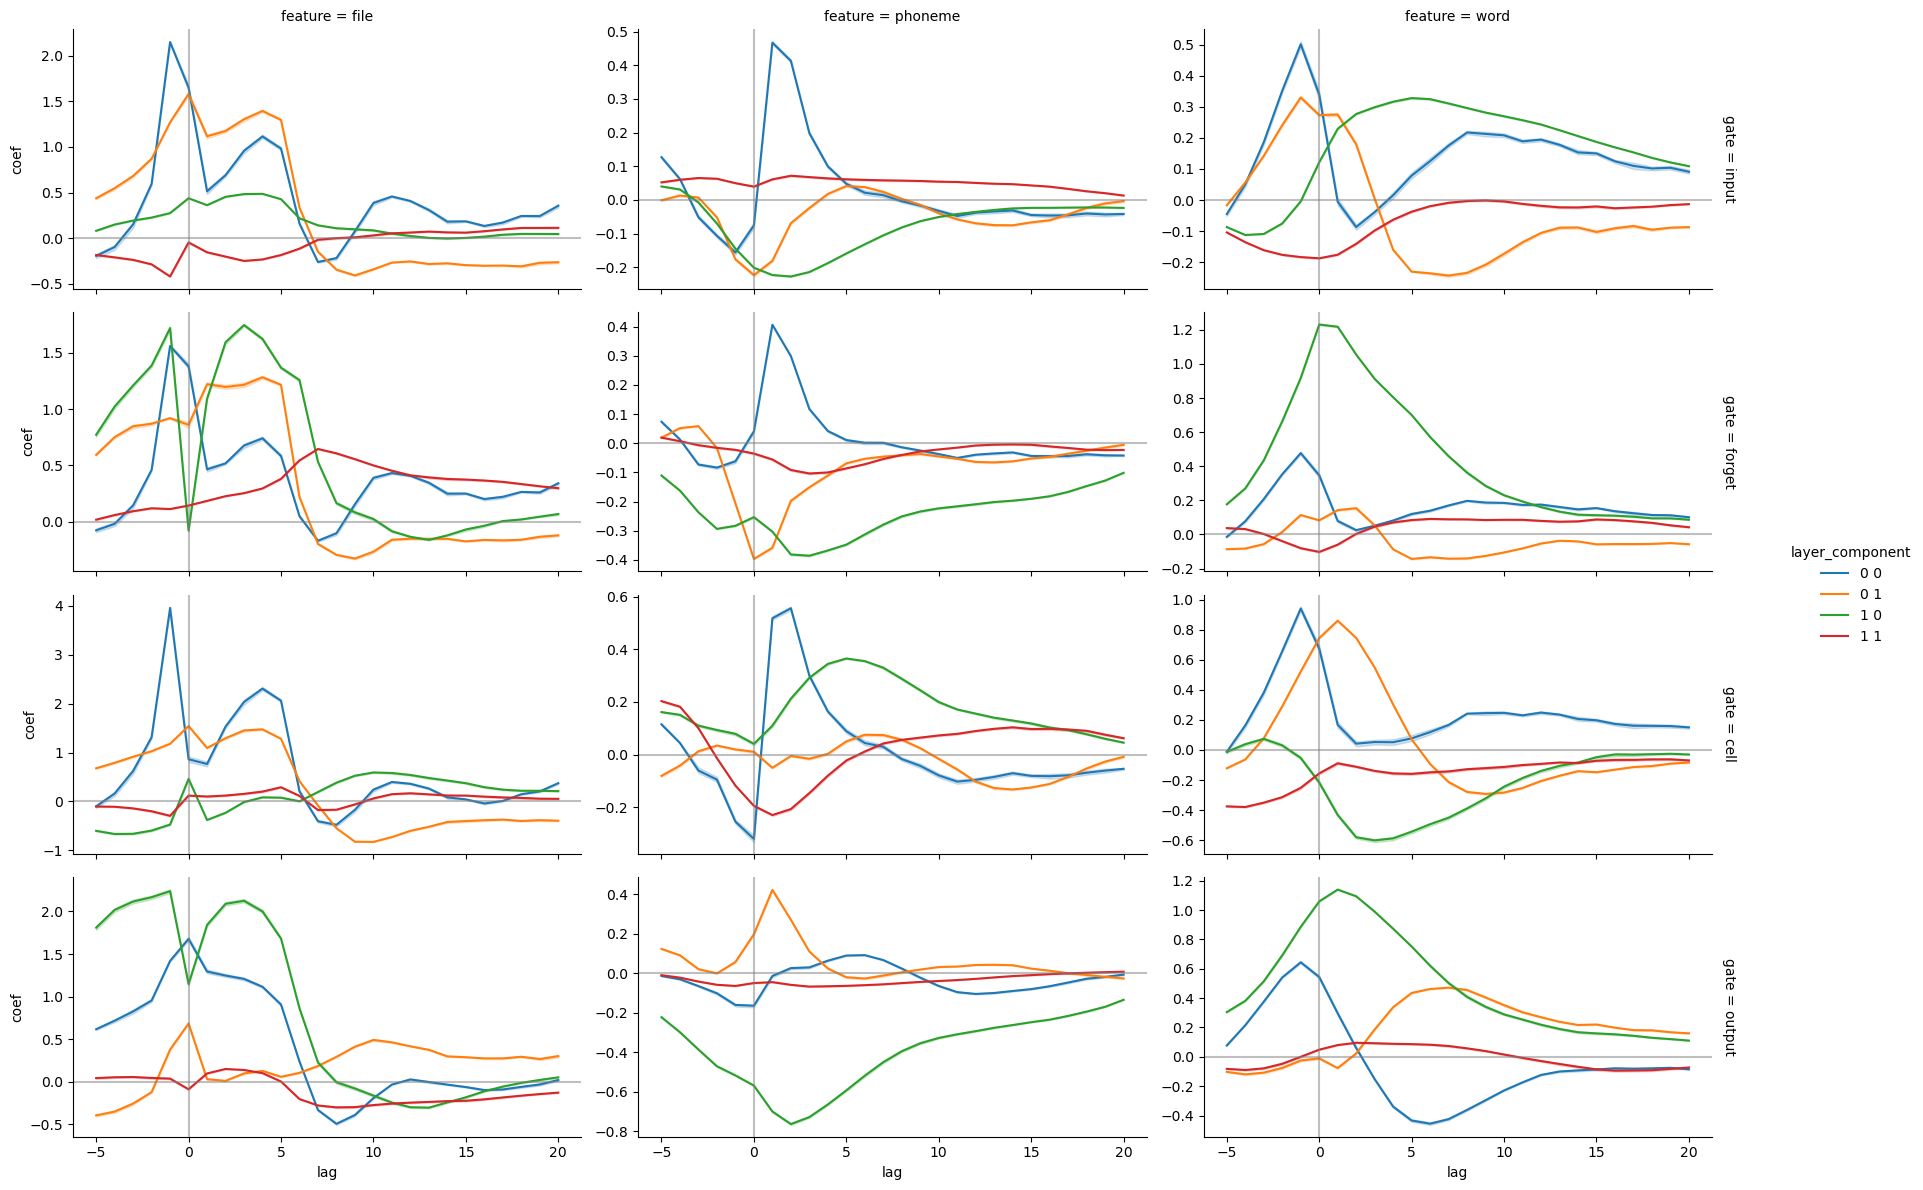

In [27]:
g = sns.FacetGrid(trf_df, row="gate", col="feature", hue="layer_component", margin_titles=True, aspect=2, sharey=False)
g.map(sns.lineplot, "lag", "coef")
g.add_legend()

for ax in g.axes.flat:
    ax.axvline(0, color="gray", alpha=0.5)
    ax.axhline(0, color="gray", alpha=0.5)

## Exploratory peak analysis

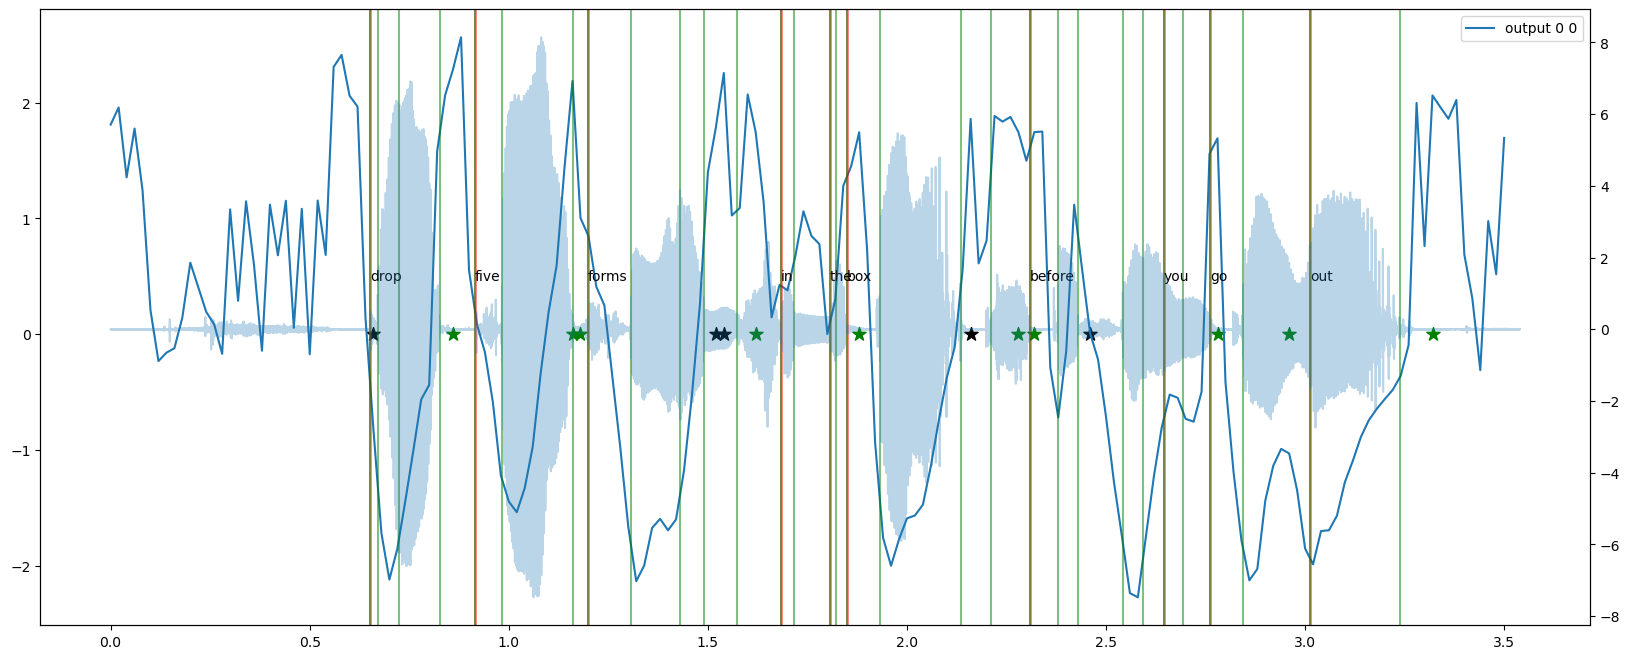

In [28]:
f, ax = plt.subplots(figsize=(20, 8))

plot_item_idx = 7
plot_item = test_dataset_sub[plot_item_idx]
plot_item_flat_idxs = np.array([idx for ((item_idx, frame), idx) in hidden_state_source_to_flat_idx.items()
                                if item_idx == plot_item_idx])
compression_ratio = model.encoder._get_feat_extract_output_lengths(len(plot_item["input_values"])) / len(plot_item["input_values"])
# assert contiguous
assert np.all(np.diff(plot_item_flat_idxs) == 1)
model_sfreq = 50
ts = (plot_item_flat_idxs - plot_item_flat_idxs.min()) / model_sfreq

ax.twinx().plot(np.arange(len(plot_item["input_values"])) / 16000, plot_item["input_values"], alpha=0.3)

# for gate_data, gate_label in zip(gate_norms[plot_item_flat_idxs].T, gate_norm_labels):
#     if "forget 1" in gate_label:
#         ax.plot(ts, gate_data, label=gate_label)
target_gate = "output 0 0"
for gate_data, gate_label in zip(gate_pcas[plot_item_flat_idxs].T, gate_pca_labels):
    # if "forget 0 0" in gate_label:
    # if gate_label in ["forget 0 0", "forget 0 1
    if gate_label == target_gate:
        ax.plot(ts, gate_data, label=gate_label)
ax.legend()

for i, word_phons in enumerate(plot_item["word_phonemic_detail"]):
    if not word_phons: continue
    ax.axvline(word_phons[0]["start"] / 16000, color="red", alpha=0.5, linewidth=2)
    ax.text(word_phons[0]["start"] / 16000, 0.5, plot_item["word_detail"]["utterance"][i],
            ha="left", va="center")
    for phon in word_phons:
        ax.axvline(phon["start"] / 16000, color="green", alpha=0.5)

import scipy.signal
# frames bounding utterance
peak_search_start = int(plot_item["word_detail"]["start"][0] * compression_ratio)
peak_search_end = int(plot_item["word_detail"]["stop"][-1] * compression_ratio)
peak_search_flat_idxs = plot_item_flat_idxs[peak_search_start:peak_search_end]
component_norm = gate_pcas[peak_search_flat_idxs, gate_pca_labels.index(target_gate)]
# component_norm -= component_norm.mean()
# component_norm /= component_norm.std()
component_norm -= component_norm.min()
component_norm /= component_norm.max()
# peak_samples = scipy.signal.find_peaks(component_norm, height=0.3)[0]
peak_samples = scipy.signal.find_peaks_cwt(component_norm, np.arange(2, 4))
peak_times = ts[peak_samples + peak_search_start]
for peak_time in peak_times:
    distance_from_gt = np.abs(peak_time - np.array(plot_item["word_detail"]["stop"]) / 16000)
    if np.any(distance_from_gt < 0.1):
        ax.scatter(peak_time, 0, color="green", marker="*", s=100)
    else:
        ax.scatter(peak_time, 0, color="black", marker="*", s=100)

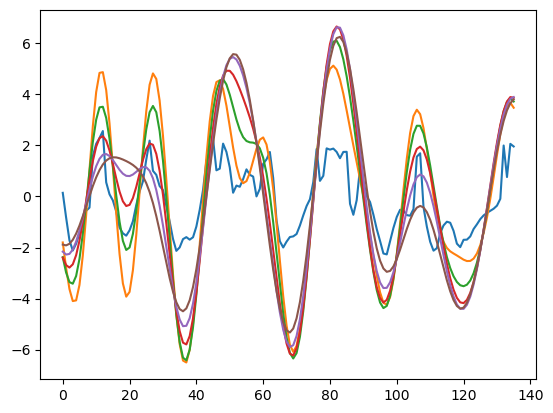

In [29]:
filter_data = gate_pcas[peak_search_flat_idxs, gate_pca_labels.index(target_gate)]
plt.plot(filter_data)

plt.plot(scipy.signal.cwt(filter_data, scipy.signal.ricker, np.arange(5, 10)).T)

# nyquist_freq = 50 / 2
# b, a = scipy.signal.butter(2, 3 / nyquist_freq, btype="low")
# plt.plot(scipy.signal.filtfilt(b, a, filter_data))

## Quantitative peak analysis

In [68]:
# analysis parameters
target_gate_component = "forget 1 0"
# for absolute peaks, parameter is % threshold
peak_method = "absolute"
peak_parameters = np.logspace(-2, 0, 10)
# # for CWT peaks, parameter is minimum width of peak
# peak_method = "cwt"
# peak_parameters = np.arange(1, 5)

if peak_method == "absolute":
    find_peaks = scipy.signal.find_peaks
    prepare_parameter = lambda x: dict(height=x)
elif peak_method == "cwt":
    find_peaks = scipy.signal.find_peaks_cwt
    prepare_parameter = lambda x: dict(widths=np.arange(x, x + 3))

random_baseline_samples = 20

predicted_peaks = np.zeros((boundary_matrix.shape[0], len(peak_parameters)))
def compute_peaks(item, idx, component_idx=0):
    compression_ratio = (model.encoder._get_feat_extract_output_lengths(len(item["input_values"])) / len(item["input_values"])).item()

    start_frame = int(item["word_detail"]["start"][0] * compression_ratio)
    stop_frame = int(item["word_detail"]["stop"][-1] * compression_ratio)

    start_flat_idx = hidden_state_source_to_flat_idx[(idx, start_frame)]
    stop_flat_idx = hidden_state_source_to_flat_idx[(idx, stop_frame)]

    component_norm = gate_pcas[start_flat_idx:stop_flat_idx, component_idx]
    component_norm -= np.nanmin(component_norm)
    component_norm /= np.nanmax(component_norm.max())

    for i, parameter in enumerate(peak_parameters):
        peak_samples = find_peaks(component_norm, **prepare_parameter(parameter))[0]
        predicted_peaks[start_flat_idx + peak_samples, i] = 1

test_dataset_sub.map(compute_peaks, with_indices=True, fn_kwargs={"component_idx": gate_pca_labels.index(target_gate_component)})
# component_norm = gate_pcas[:, gate_pca_labels.index(target_gate_component)].copy()
# component_norm[~span_mask] = np.nanmean(component_norm)
# # component_norm -= component_norm.mean()
# # component_norm /= component_norm.std()
# component_norm -= np.nanmin(component_norm)
# component_norm /= np.nanmax(component_norm.max())

# # TODO mask out spans before sentence onset / after sentence offset
# for i, parameter in enumerate(tqdm(peak_parameters)):
#     peak_samples = find_peaks(component_norm, **prepare_parameter(parameter))[0]
#     predicted_peaks[peak_samples, i] = 1

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'phonemic_detail', 'word_phonetic_detail', 'word_phonemic_detail', 'input_values', 'phone_targets', 'idx', 'predicted_segments'],
    num_rows: 1680
})

[ 36  39  42  44  49  51  58  63  70  75  80  83  85  91  95 100 108 115
 121 125 138 142 150 164] [0.72 0.78 0.84 0.88 0.98 1.02 1.16 1.26 1.4  1.5  1.6  1.66 1.7  1.82
 1.9  2.   2.16 2.3  2.42 2.5  2.76 2.84 3.   3.28]


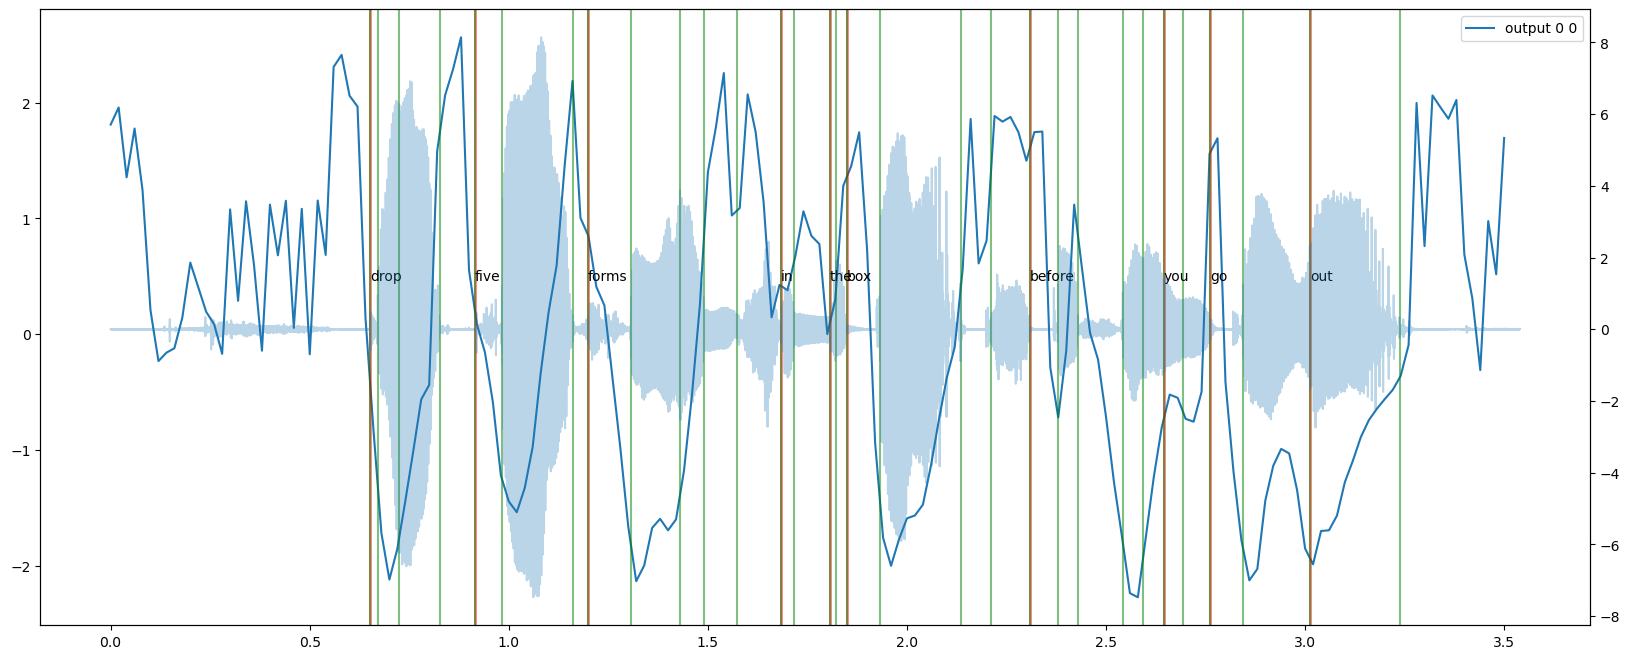

In [72]:
f, ax = plt.subplots(figsize=(20, 8))

plot_item_idx = 7
plot_item = test_dataset_sub[plot_item_idx]
plot_item_flat_idxs = np.array([idx for ((item_idx, frame), idx) in hidden_state_source_to_flat_idx.items()
                                if item_idx == plot_item_idx])
compression_ratio = model.encoder._get_feat_extract_output_lengths(len(plot_item["input_values"])) / len(plot_item["input_values"])
# assert contiguous
assert np.all(np.diff(plot_item_flat_idxs) == 1)
model_sfreq = 50
ts = (plot_item_flat_idxs - plot_item_flat_idxs.min()) / model_sfreq

ax.twinx().plot(np.arange(len(plot_item["input_values"])) / 16000, plot_item["input_values"], alpha=0.3)

# for gate_data, gate_label in zip(gate_norms[plot_item_flat_idxs].T, gate_norm_labels):
#     if "forget 1" in gate_label:
#         ax.plot(ts, gate_data, label=gate_label)
target_gate = "output 0 0"
for gate_data, gate_label in zip(gate_pcas[plot_item_flat_idxs].T, gate_pca_labels):
    # if "forget 0 0" in gate_label:
    # if gate_label in ["forget 0 0", "forget 0 1
    if gate_label == target_gate:
        ax.plot(ts, gate_data, label=gate_label)
ax.legend()

for i, word_phons in enumerate(plot_item["word_phonemic_detail"]):
    if not word_phons: continue
    ax.axvline(word_phons[0]["start"] / 16000, color="red", alpha=0.5, linewidth=2)
    ax.text(word_phons[0]["start"] / 16000, 0.5, plot_item["word_detail"]["utterance"][i],
            ha="left", va="center")
    for phon in word_phons:
        ax.axvline(phon["start"] / 16000, color="green", alpha=0.5)

item_predicted_peaks = predicted_peaks[plot_item_flat_idxs, 0].nonzero()[0]
item_predicted_peak_times = ts[item_predicted_peaks]
print(item_predicted_peaks, item_predicted_peak_times)

In [31]:
# Add random baselines which randomly sample word boundaries at the same
# rate as the predicted peaks
random_baseline = np.zeros((*predicted_peaks.shape, random_baseline_samples))
for i in tqdm(range(len(peak_parameters))):
    base_rate = predicted_peaks[:, i].mean()
    for j in range(random_baseline_samples):
        random_baseline[:, i, j] = np.random.rand(predicted_peaks.shape[0]) < base_rate

  0%|          | 0/10 [00:00<?, ?it/s]

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

# For a window of `frame_tolerance` frames around each index, compare whether any of the frames are annotated as a boundary
# and whether they are predicted as a boundary.
frame_tolerance = 3

# K-fold split over only window centers, since a K-fold split over individual frames
# would yield dependent samples.
window_centers = np.arange(frame_tolerance, boundary_matrix.shape[0] - frame_tolerance, frame_tolerance)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splitter = kf.split(window_centers)

precision_recall_f1_scores = []
for fold_idx, (_, test_idx) in enumerate(tqdm(splitter)):
    y_true, y_pred, y_pred_random = [], [], []
    for idx in test_idx:
        window_center = window_centers[idx]
        gt_word_boundary = boundary_matrix[max(0, window_center - frame_tolerance) : window_center + frame_tolerance, boundary_event_to_idx["word"]].any()
        pred_word_boundary = predicted_peaks[max(0, window_center - frame_tolerance) : window_center + frame_tolerance].any(axis=0)
        random_word_boundary = random_baseline[max(0, window_center - frame_tolerance) : window_center + frame_tolerance].any(axis=0)

        y_true.append(gt_word_boundary)
        y_pred.append(pred_word_boundary)
        y_pred_random.append(random_word_boundary)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_random = np.array(y_pred_random)

    for i, parameter in enumerate(peak_parameters):
        precision_recall_f1_scores.append((i, parameter, fold_idx, False,
                                           precision_score(y_true, y_pred[:, i]),
                                           recall_score(y_true, y_pred[:, i]),
                                           f1_score(y_true, y_pred[:, i])))
        
        for j in range(random_baseline_samples):
            precision_recall_f1_scores.append((i, parameter, fold_idx, True,
                                               precision_score(y_true, y_pred_random[:, i, j]),
                                               recall_score(y_true, y_pred_random[:, i, j]),
                                               f1_score(y_true, y_pred_random[:, i, j])))


0it [00:00, ?it/s]

/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/userdata/jgauthier/transformers/lib/python3.10/site-packages

In [33]:
segmentation_outcome_df = pd.DataFrame(precision_recall_f1_scores, columns=["parameter_idx", "parameter", "fold_idx", "random_baseline", "precision", "recall", "f1"]) \
    .melt(id_vars=["parameter_idx", "parameter", "fold_idx", "random_baseline"], value_vars=["precision", "recall", "f1"], var_name="metric", value_name="score")
segmentation_outcome_df.head()

,parameter_idx,parameter,fold_idx,random_baseline,metric,score
0,0,0.01,0,False,precision,0.398227
1,0,0.01,0,True,precision,0.324784
2,0,0.01,0,True,precision,0.322436
3,0,0.01,0,True,precision,0.322136
4,0,0.01,0,True,precision,0.321880


<Axes: xlabel='parameter', ylabel='score'>

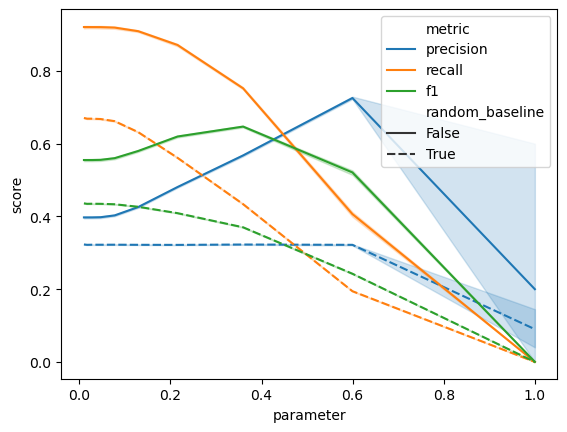

In [34]:
sns.lineplot(data=segmentation_outcome_df, x="parameter", y="score", hue="metric", style="random_baseline")

In [35]:
segmentation_outcome_df.to_csv("20231123 segmentation outcome.csv", index=False)

In [37]:
segmentation_outcome_df[segmentation_outcome_df.metric == "f1"].groupby("parameter").apply(lambda xs: xs[~xs.random_baseline].score.mean() - xs[xs.random_baseline].score.mean())

parameter
0.010000    0.119094
0.016681    0.120449
0.027826    0.120258
0.046416    0.120950
0.077426    0.126752
0.129155    0.153516
0.215443    0.210769
0.359381    0.276987
0.599484    0.278595
1.000000    0.000100
dtype: float64

In [39]:
peak_parameters[7]

0.3593813663804626

Viz options:
- vowel-vowel transitions vs. others. requires building a little aug matrix
- over- and under- segmentation. also requires an aug matrix

Maybe most efficient to just put the segmentation data back into eval_dataset! yeah!
and maybe we'll loop this in with 

In [42]:
predicted_peaks = find_peaks(component_norm, **prepare_parameter(peak_parameters[7]))[0]

In [63]:
def add_segmentation_predictions(item, idx):
    compression_ratio = model.encoder._get_feat_extract_output_lengths(len(item["input_values"])) / len(item["input_values"])
    item_flat_start = hidden_state_source_to_flat_idx[idx, 0]
    item_flat_end = hidden_state_source_to_flat_idx[idx, int(len(item["input_values"]) * compression_ratio) - 1]
    if item_flat_start == item_flat_end:
        raise ValueError()
    predicted_peak_frames = predicted_peaks[item_flat_start:item_flat_end].copy()
    predicted_peak_times = predicted_peak_frames / 50
    predicted_peak_samples = predicted_peak_times * 16000
    item["predicted_segments"] = predicted_peak_samples
    return item

test_dataset_sub = test_dataset_sub.map(add_segmentation_predictions, with_indices=True)

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

In [65]:
lengths = np.array([len(pred) for pred in test_dataset_sub["predicted_segments"]])

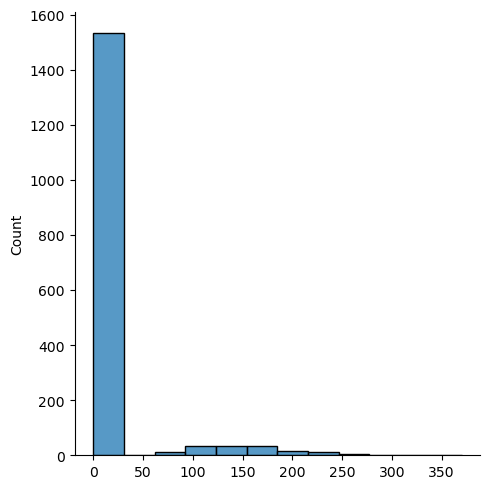

In [66]:
sns.displot(lengths)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]


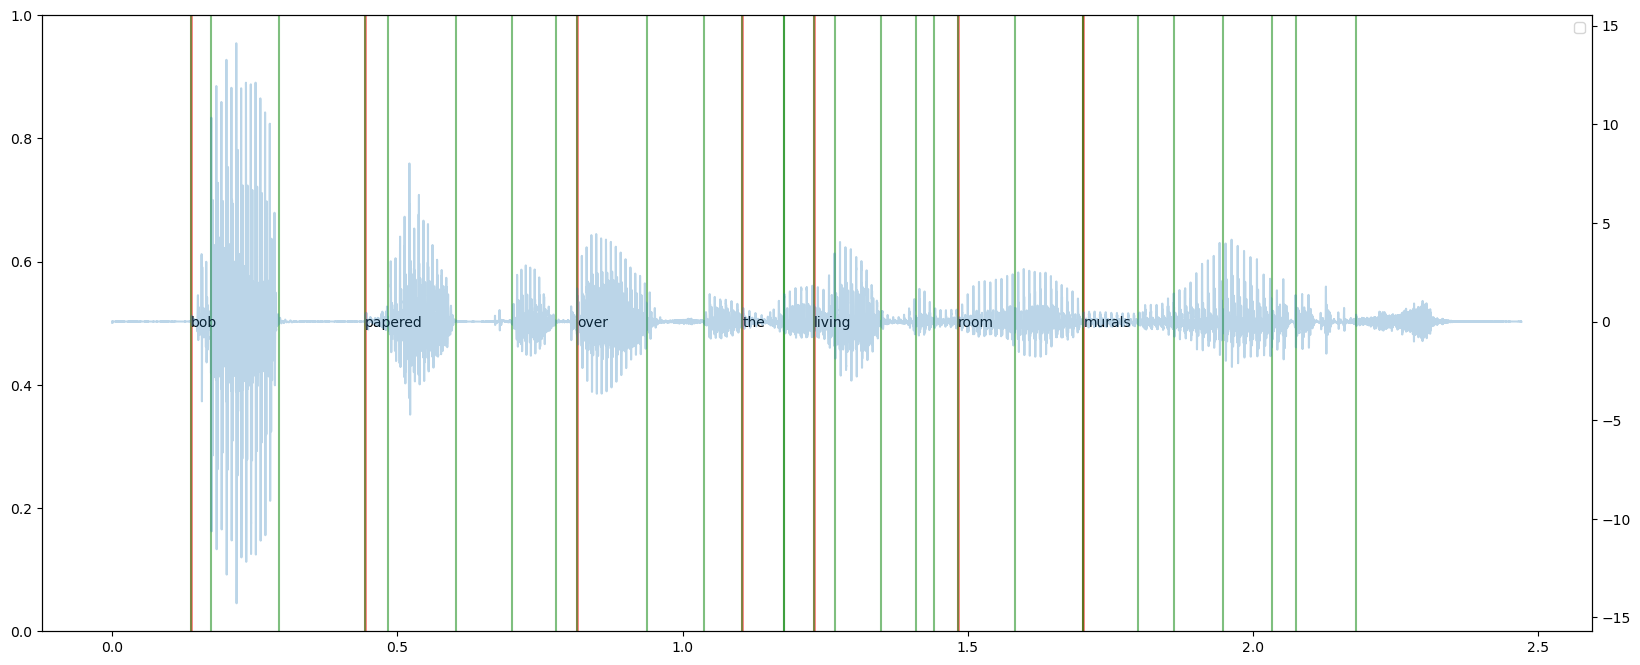

In [56]:
f, ax = plt.subplots(figsize=(20, 8))

plot_item_idx = np.random.choice(len(test_dataset_sub))
plot_item = test_dataset_sub[plot_item_idx]
plot_item_flat_idxs = np.array([idx for ((item_idx, frame), idx) in hidden_state_source_to_flat_idx.items()
                                if item_idx == plot_item_idx])
compression_ratio = model.encoder._get_feat_extract_output_lengths(len(plot_item["input_values"])) / len(plot_item["input_values"])
# assert contiguous
assert np.all(np.diff(plot_item_flat_idxs) == 1)
model_sfreq = 50
ts = (plot_item_flat_idxs - plot_item_flat_idxs.min()) / model_sfreq

ax.twinx().plot(np.arange(len(plot_item["input_values"])) / 16000, plot_item["input_values"], alpha=0.3)

# # for gate_data, gate_label in zip(gate_norms[plot_item_flat_idxs].T, gate_norm_labels):
# #     if "forget 1" in gate_label:
# #         ax.plot(ts, gate_data, label=gate_label)
# target_gate = "output 0 0"
# for gate_data, gate_label in zip(gate_pcas[plot_item_flat_idxs].T, gate_pca_labels):
#     # if "forget 0 0" in gate_label:
#     # if gate_label in ["forget 0 0", "forget 0 1
#     if gate_label == target_gate:
#         ax.plot(ts, gate_data, label=gate_label)
ax.legend()

for i, word_phons in enumerate(plot_item["word_phonemic_detail"]):
    if not word_phons: continue
    ax.axvline(word_phons[0]["start"] / 16000, color="red", alpha=0.5, linewidth=2)
    ax.text(word_phons[0]["start"] / 16000, 0.5, plot_item["word_detail"]["utterance"][i],
            ha="left", va="center")
    for phon in word_phons:
        ax.axvline(phon["start"] / 16000, color="green", alpha=0.5)

print(plot_item["predicted_segments"])
for sample in plot_item["predicted_segments"]:
    ax.axvline(sample / 16000, color="blue", alpha=0.5)

# import scipy.signal
# # frames bounding utterance
# peak_search_start = int(plot_item["word_detail"]["start"][0] * compression_ratio)
# peak_search_end = int(plot_item["word_detail"]["stop"][-1] * compression_ratio)
# peak_search_flat_idxs = plot_item_flat_idxs[peak_search_start:peak_search_end]
# component_norm = gate_pcas[peak_search_flat_idxs, gate_pca_labels.index(target_gate)]
# # component_norm -= component_norm.mean()
# # component_norm /= component_norm.std()
# component_norm -= component_norm.min()
# component_norm /= component_norm.max()
# # peak_samples = scipy.signal.find_peaks(component_norm, height=0.3)[0]
# peak_samples = scipy.signal.find_peaks_cwt(component_norm, np.arange(2, 4))
# peak_times = ts[peak_samples + peak_search_start]
# for peak_time in peak_times:
#     distance_from_gt = np.abs(peak_time - np.array(plot_item["word_detail"]["stop"]) / 16000)
#     if np.any(distance_from_gt < 0.1):
#         ax.scatter(peak_time, 0, color="green", marker="*", s=100)
#     else:
#         ax.scatter(peak_time, 0, color="black", marker="*", s=100)